# Math 300: Recitation 10

# Composing Algorithms

In a similar vein to the last problem, we can compose other algorithms that we have worked with together to solve problems. Consider some data generated by $\sin(x)$:

In [1]:
xvals = collect(0.:1.:2*pi)
yvals = sin.(xvals)
data = collect(zip(xvals, yvals))

7-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (1.0, 0.8414709848078965)
 (2.0, 0.9092974268256817)
 (3.0, 0.1411200080598672)
 (4.0, -0.7568024953079282)
 (5.0, -0.9589242746631385)
 (6.0, -0.27941549819892586)

The goal is to approximate the root of $\sin(x)$ in $(0, 2\pi)$ (notice the lack of inclusion). Given data of this form, we can construct an interpolant, using `DataInterpolations.jl`:

In [2]:
using DataInterpolations
interpolant = LagrangeInterpolation(yvals, xvals)

[ Info: Precompiling DataInterpolations [82cc6244-b520-54b8-b5a6-8a565e85f1d0]


LagrangeInterpolation with 7 points, with order 6
┌──────┬───────────┐
│ time │         u │
├──────┼───────────┤
│  0.0 │       0.0 │
│  1.0 │  0.841471 │
│  2.0 │  0.909297 │
│  3.0 │   0.14112 │
│  4.0 │ -0.756802 │
│  5.0 │ -0.958924 │
│  6.0 │ -0.279415 │
└──────┴───────────┘


We can evaluate the interpolant away from the nodes:

In [3]:
println(interpolant(pi)) # Expect that this is near zero

0.0008035640989909893


[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b]


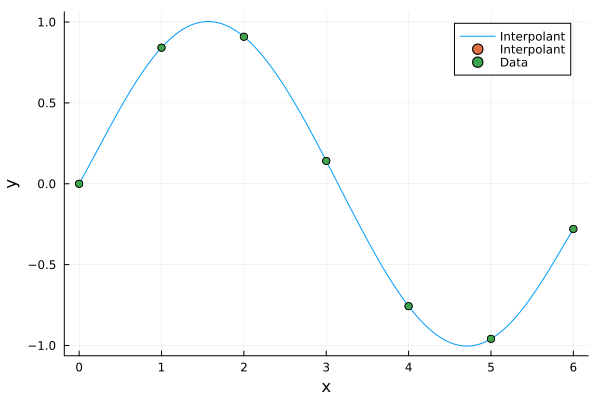

In [4]:
using Plots
plot(interpolant, xlabel = "x", ylabel = "y", label = "Interpolant")
scatter!(xvals, sin.(xvals), label = "Data")

Now, we can use an algorithm for rootfinding **on the interpolant** to approximate the root of the function which generated the original data. We can do that using `Roots.jl` with our interpolant constructed from `DataInterpolations.jl`:

In [5]:
using Roots
root = find_zero(interpolant, (xvals[2], xvals[end - 1])) # Don't include boundary points where roots are

[ Info: Precompiling RootsForwardDiffExt [a63bd285-541a-50a0-818b-605bb84ce7b2]


3.142400555647766

We can check the error from the true solution (which is of course $\pi$):

In [7]:
abs(root - pi)

0.0008079020579727647

Not bad! Adding more points makes it even better:

In [8]:
using DataInterpolations, Roots
xvals = collect(0.:0.5:2*pi)
yvals = sin.(xvals)
interpolant = LagrangeInterpolation(yvals, xvals)
root = find_zero(interpolant, (xvals[2], xvals[end - 1]))
abs(root - pi)

2.2629147444774844e-9

So, we see that given data, we can also do rootfinding by first constructing an interpolant of the data (also called a **surrogate**) and then doing rootfinding with that function.

I also want to demonstrate **Runge's Phenomenon**, which is something that can happen when doing Lagrange interpolation on certain types of data. You would expect that using more data points would lead to more accurate approximations, but surprisingly, this is not always the case:

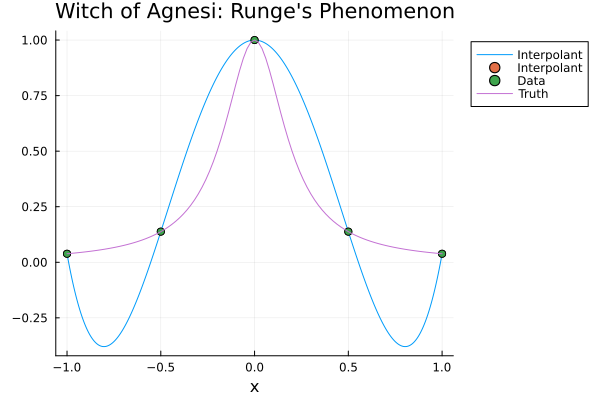

In [9]:
using Plots
f(x) = 1/(1 + 25*x^2)
xvals = collect(-1:0.5:1)
yvals = f.(xvals)
interpolant = LagrangeInterpolation(yvals, xvals)
plot(interpolant, xlabel = "x", label = "Interpolant", legend = :outertopright,
    title = "Witch of Agnesi: Runge's Phenomenon")
scatter!(xvals, yvals, label = "Data")

fine_mesh = LinRange(-1, 1, 101)
plot!(fine_mesh, f.(fine_mesh), label = "Truth")

This does not look immediately alarming, but what if we increased the number of points in the dataset?

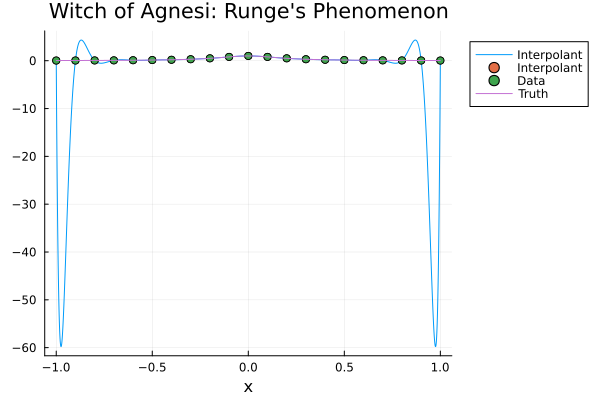

In [10]:
f(x) = 1/(1 + 25*x^2)
xvals = collect(-1:0.1:1)
yvals = f.(xvals)
interpolant = LagrangeInterpolation(yvals, xvals)
plot(interpolant, xlabel = "x", label = "Interpolant", legend = :outertopright,
    title = "Witch of Agnesi: Runge's Phenomenon")
scatter!(xvals, yvals, label = "Data")

fine_mesh = LinRange(-1, 1, 101)
plot!(fine_mesh, f.(fine_mesh), label = "Truth")

Now, the interpolant is behaving wildly near the ends of the interval. And it gets even worse:

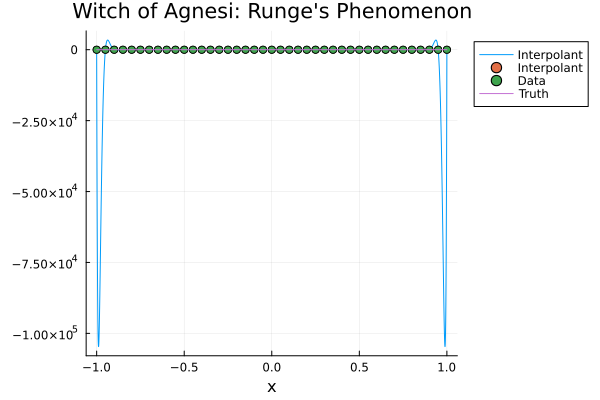

In [11]:
f(x) = 1/(1 + 25*x^2)
xvals = collect(-1:0.05:1)
yvals = f.(xvals)
interpolant = LagrangeInterpolation(yvals, xvals)
plot(interpolant, xlabel = "x", label = "Interpolant", legend = :outertopright,
    title = "Witch of Agnesi: Runge's Phenomenon")
scatter!(xvals, yvals, label = "Data")

fine_mesh = LinRange(-1, 1, 101)
plot!(fine_mesh, f.(fine_mesh), label = "Truth")

You may ask: This looks bad! Does the error bound tell us that it could be this bad? The answer: Yes, of course it does! Recall the form of the error: $\newline \newline$
$$
f(x) - P(x) = \frac{f^{(n + 1)}(\xi)}{(n + 1)!}\prod_{k = 0}^{n}(x - x_{k}).
\newline
$$
Really, if we are evaluating at a point, the thing that can go wrong is that the derivative might be excessively large.

In [13]:
using ForwardDiff
df(x) = ForwardDiff.derivative(f, x)
df(1 - 1e-3)

-0.07417540587889786

In [16]:
using TaylorSeries
# Taylor expand f about the point 1
t = taylor_expand(f, 1.; order = 100)
println(t)
t(0.) ≈ f(1.)

[ Info: Precompiling TaylorSeries [6aa5eb33-94cf-58f4-a9d0-e4b2c4fc25ea]


 0.038461538461538464 - 0.07396449704142012 t + 0.10525716886663632 t² - 0.1312979237421659 t³ + 0.15128719097855334 t⁴ - 0.16468890212975074 t⁵ + 0.17124097430860397 t⁶ - 0.17095485239178576 t⁷ + 0.16410454853362266 t⁸ - 0.15120600449563423 t⁹ + 0.13298794274773632 t¹⁰ - 0.11035565480753694 t¹¹ + 0.08434939121859378 t¹² - 0.05609916118235637 t¹³ + 0.026777818409729762 t¹⁴ + 0.002445696502785426 t¹⁵ - 0.030451164822404436 t¹⁶ + 0.056208301098099475 t¹⁷ - 0.0788129205517255 t¹⁸ + 0.09751686538976106 t¹⁹ - 0.11175077906518906 t²⁰ + 0.12113912763520872 t²¹ - 0.12550718865887345 t²² + 0.1248800477716713 t²³ - 0.1194739489273742 t²⁴ + 0.10968062507988184 t²⁵ - 0.09604548195422066 t²⁶ + 0.0792407104120764 t²⁷ - 0.060034556605704 t²⁸ + 0.03925807961474192 t²⁹ - 0.017770771753634455 t³⁰ - 0.003573592411031736 t³¹ + 0.023959573630478775 t³² - 0.04263995658646713 t³³ + 0.05896186494466875 t³⁴ - 0.07238824356045227 t³⁵ + 0.08251405978484211 t³⁶ - 0.08907680385503071 t³⁷ + 0.09196110377424932 t³⁸ 

true

In [17]:
# Calculate a derivative of the Taylor expansion at 1 - 1e-3
println(differentiate(t, 1)(-1e-3))
differentiate(t, 1)(-1e-3) ≈ df(1 - 1e-3)

-0.07417540587889786


true

In [18]:
# Print some (scaled) maximums of derivatives of the function
xvals = collect(-1:0.01:1)
for n = 1:50
    println(maximum(differentiate(t, n + 1).(xvals))/factorial(big(n + 1)))
end

63.6400691670437055336151388473808765411376953125
7456.16333879794183303602039813995361328125
50903.8483612746931612491607666015625
2.39936416018040428558985392252604166666666666666666666666666666666666666666665e+06
1.562854414818171660105387369791666666666666666666666666666666666666666666666671e+07
2.689081337298349047464037698412698412698412698412698412698412698412698412698416e+08
2.464211034989200846354166666666666666666666666666666666666666666666666666666657e+09
2.531673033397213403880070546737213403880070546737213403880070546737213403880067e+10
2.315497309619289241622574955908289241622574955908289241622574955908289241622582e+11
1.90414649368705703383036716370049703383036716370049703383036716370049703383037e+12
1.847239749700943094436427769761103094436427769761103094436427769761103094436433e+13
9.658158210661094832870832870832870832870832870832870832870832870832870832870892e+13
1.233505799669790345600031949238298444647650996857346063695270044476393682742896e+15
3.476833055540858075

We see that the term $\newline \newline$
$$
\frac{1}{(n + 1)!}\max_{\xi \in (-1, 1)}|f^{n + 1}(\xi)|
\newline
$$
is blowing up as $n$ is getting larger. Thus, the error bounds are containing the information about Runge's Phenomenon.